In [21]:
%matplotlib inline
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import sqlite3 as lite
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
import time
#from modules.backtesting import BackTester
from modules.db_manager import open_file, product_info
pd.options.display.float_format = '{:,.2f}'.format #화면에 소숫점 2번째 자리까지만 표시

In [22]:
raw_file =  open_file('h5py', 'training set/40day_trend_labeled_futures.h5', mode='r')

In [326]:
class UnitTrade:
    """
    상품별로 전략을 테스트 하는 클래스
    """

    def __init__(self, feed, pinfo, principal):
        self.feed = feed #pandas dataframe 상품 가격 데이터 
        self.pinfo = pinfo #xingapi로 받아온 상품 기초정보
        self.principal = principal
        self._statement = [] #총평가기록
        self._tradelog = [] #매매기록
        self._equitylog = [] #자산곡선

    def get_profit(self, position, lot, entryprice, exitprice):
        return position * lot * (exitprice - entryprice)/self.pinfo['tick_unit']
    
    def get_lot(self, unit):
        return int(unit/self.pinfo['open_margin'])

    def report(self):
        return BackTester.get_result(self.statement, self.pinfo['name'])

    def plot(self):
        statement = self.statement
        fig, (ax) = plt.subplots(2,1, figsize=(12,10))
        ax[0].plot(self.data.close)
        for _,position, entrydate, exitdate in statement[['position','entrydate','exitdate']].itertuples():
            color = 'red' if position == 1 else 'green'
            ax[0].axvspan(entrydate, exitdate, facecolor=color, alpha=0.3)

        ax[1].plot(statement.entrydate, statement.cumprofit)
        ax[1].plot(statement.entrydate, statement.cumprofit.cummax())

        return ax[0]
    
    @property
    def statement(self):
        
        statement = self.tradelog
        statement['pro_per_lot'] = statement.position*(statement.exitprice - statement.entryprice)/self.pinfo['tick_unit']
        
        statement['profit'] = statement.position*(statement.exitprice - statement.entryprice)/self.pinfo['tick_unit']
        statement['cumprofit'] = statement.profit.cumsum()
        statement['drawdown'] = statement.cumprofit.cummax() - statement.cumprofit
        statement.insert(0, 'name', self.pinfo['name'])
        #receipt['drawdown'] = (1- receipt.cumprofit / receipt.cumprofit.cummax())*100 
        return statement
    
    @property
    def equitylog(self):
        """
        평가 손익을 포함한 자산 변화 테이블 생성
        """
        columns = ['date','balance','open profit','equity']
        return pd.DataFrame(self._equitylog, columns=columns)
    
    @property
    def tradelog(self):
        """
        매매 테이블 생성
        """
        columns = ['entryid','position','entrylot', 'entrydate', 'entryprice','exitlot', 'exitdate', 'exitprice']
        log = pd.DataFrame(self._tradelog, columns=columns)
        log['profit'] = log.position * log.exitlot * (log.exitprice - log.entryprice)/self.pinfo['tick_unit']
        log.insert(0, 'symbol', self.pinfo['group']) 
        return log

In [331]:
class BackTester:

    def __init__(self, feed=None, strategy=None, name='STRATEGY', principal=1000000):
        
        self.feed = feed
        self.columns = feed.attrs['columns'].split(';')
        self.name = name    
        
        self.products = product_info()#self._get_meta(BackTester.INFO_PATH)

        self.principal = principal
        self.trades = []

        if strategy:
            self.strategy = strategy           
        else: 
            self.strategy = self.default_strategy

        
    @property
    def statement(self):
        return self._statement

    
    def report(self, level=0):
        if level == 0:
            report = BackTester.get_result(self._statement, self.name)
            
        elif level == 1:
            report = BackTester.get_result(self._statement, self.name)
            report = report.append(pd.concat([item.report() for item in self.trades]))
        
        return report
    
    
    def summary(self, level=0):
        self.plot()
        return self.report(level)
    
    def run(self):
        print("trading started. it takes few minutes...")
        for idx, raw in enumerate(self.feed.values()):
            symbol = raw.attrs['symbol']
            #이베스트 미거래종목 제외
            if symbol == 'None' or not symbol:
                continue

            else:
                data = pd.DataFrame(raw.value[:,1:], index=raw.value[:,0].astype('M8[s]'), columns=self.columns[1:])
                data.insert(0,'date', data.index)
                
                trade = UnitTrade(data, self.products[symbol], self.principal)
                self.strategy(trade)
                self.trades.append(trade)

                print(f'\rprocessing..({idx})', end='', flush=True)
        
        self._statement = pd.concat([trade.statement for trade in self.trades])[['name','entrydate','exitdate','profit']]
        self._statement.sort_values('entrydate', inplace=True)
        self._statement.reset_index(drop=True, inplace=True)
        self._statement['cumprofit'] = self._statement.profit.cumsum()
        self._statement['drawdown'] = self._statement.cumprofit.cummax() - self._statement.cumprofit
        
        print("\nDone")

    
    def plot(self):
        x = self._statement.entrydate.values
        y1 = self._statement.cumprofit.values
        y2 = self._statement.cumprofit.cummax().values
        fig, ax = plt.subplots(1,1, figsize=(10, 8))
        ax.fill_between(x, 0, y1, where=y1>=0, facecolor='green',alpha=0.4, interpolate=True)
        ax.fill_between(x, 0, y1, where=y1<0, facecolor='red', alpha=0.8, interpolate=True)
        ax.fill_between(x,y1, y2, color='grey', alpha=0.2)

        #labels
        ax.set_title('Cumulative Profit')
        ax.set_xlabel('Date')
        ax.set_ylabel('Profit')
        ax.yaxis.set_label_position("right")
        
        #style
        ax.grid(linestyle='--')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.yaxis.tick_right()
        fig.autofmt_xdate()
        
        plt.show()    
    
    @staticmethod
    def get_result(statement, name):
        #receipt = self.receipt
        #mdd = 100*(statement.drawdown/statement.cumprofit.cummax()).max()
        mdd = statement.drawdown.max()
        cum_profit = statement.cumprofit.iloc[-1]
        ave_profit = statement.profit.mean()
        rng = statement.exitdate.max() - statement.entrydate.min()
        rng = rng.days/365
        cagr = pow(cum_profit, 1/rng) - 1 if cum_profit > 0 else 0
        win_rate = 100 * statement.profit[statement.profit >= 0].count() \
                    / statement.profit.count()
        max_loss = statement.profit.min()
        max_profit = statement.profit.max()
        #ave_win = statement.profit[receipt.profit >= 0].mean()
        #ave_lose = statement.profit[receipt.profit < 0].mean()
        profit_factor = abs(statement.profit[statement.profit >=0].sum()/\
                       statement.profit[statement.profit < 0].sum())
        num_trade = len(statement) / rng # 연평균 매매 횟수

        data = [[cum_profit, cagr, profit_factor, mdd, win_rate, max_profit, max_loss, num_trade]]
        columns = ['총손익(틱)','CAGR(%)','손익비','MDD(틱)','승률(%)', '최대수익(틱)','최대손실(틱)','연평균 매매횟수']
        return pd.DataFrame(data, index=[name], columns=columns)
    
    @staticmethod
    def default_strategy(trade):
        """
        default: buy only ma cross system
        진입: 20종가이평이 60종가이평 돌파상승 한 다음날 시가 진입
        청산: 20종가이평이 60종가이평 돌파하락 한 다음날 시가 청산
        
        매매랏수: 1랏
        랏당가격: 250유닛
        """
        LONG = 1
        SHORT = -1
        
        data = trade.feed
        data['ma20'] = data.close.rolling(30).mean()
        data['ma60'] = data.close.rolling(200).mean()
        data['cross'] = (data.ma20 > data.ma60).astype('int')
        data['signal'] = data.cross.diff().shift(1)
        data.dropna(inplace=True)
        
        entryid = 0
        lot = 0 #잔여 랏수
        clo_bal = trade.principal #확정자산
        profit = 0
        
        for date, open, close, signal in data[['open','close','signal']].itertuples():
            if signal == 1:
                entryid += 1
                position = LONG #진입 포지션
                entrylot = 1 #진입 랏수
                entryprice = open #진입 가격
                entrydate = date #진입 날짜
                lot = lot + entrylot #잔여 랏수
                
            if signal == -1:
                exitlot = 1 #청산 랏수
                exitprice = open #청산 가격
                exitdate = date #청산 날짜
                lot = lot - exitlot #잔여 랏수
                trade._tradelog.append([entryid, position, entrylot, entrydate, entryprice, 
                                 exitlot, exitdate, exitprice])
                
                profit = trade.get_profit(position,  exitlot, entryprice, exitprice)
                                            
            else:
                profit = 0
            
            
            if lot:
                open_profit = trade.get_profit(position, lot, entryprice, close)
            else:
                open_profit = 0
                
           
            clo_bal = clo_bal + profit
            equity = clo_bal + open_profit
            trade._equitylog.append([date, clo_bal, open_profit, equity])
            

In [332]:
#columns = raw_file.attrs['columns'].split(';')
back = BackTester(feed=raw_file)

In [333]:
ret = back.run()

trading started. it takes few minutes...
processing..(61)
Done


In [364]:
a = back.trades[10]

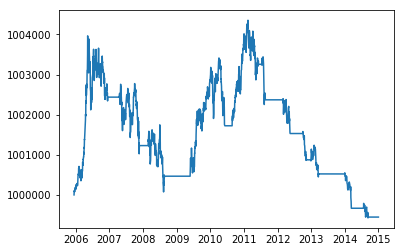

In [365]:
plt.plot(a.equitylog.date, a.equitylog.equity)

In [366]:
a.tradelog

,symbol,entryid,position,entrylot,entrydate,entryprice,exitlot,exitdate,exitprice,profit
0,HG,1,1,1,2005-12-15,2.33,1,2006-12-14,3.55,"2,437.00"
1,HG,2,1,1,2007-04-19,4.04,1,2007-11-26,3.44,"-1,208.00"
2,HG,3,1,1,2008-02-27,4.21,1,2008-08-21,3.83,-763.00
3,HG,4,1,1,2009-05-28,2.46,1,2010-06-07,3.09,"1,257.00"
4,HG,5,1,1,2010-08-27,3.55,1,2011-06-10,4.31,"1,532.00"
5,HG,6,1,1,2011-07-13,4.58,1,2011-08-23,4.13,-885.00
6,HG,7,1,1,2012-02-29,4.07,1,2012-05-16,3.65,-840.00
7,HG,8,1,1,2012-10-02,3.90,1,2012-11-12,3.57,-656.00
8,HG,9,1,1,2012-12-28,3.71,1,2013-03-22,3.54,-351.00
9,HG,10,1,1,2013-12-30,3.48,1,2014-03-12,3.05,-856.00


In [349]:
a.equitylog

,date,balance,open profit,equity
0,2005-12-06,"1,000,000.00",0.00,"1,000,000.00"
1,2005-12-07,"1,000,000.00",0.00,"1,000,000.00"
2,2005-12-08,"1,000,000.00",0.00,"1,000,000.00"
3,2005-12-09,"1,000,000.00",0.00,"1,000,000.00"
4,2005-12-12,"1,000,000.00",0.00,"1,000,000.00"
5,2005-12-13,"1,000,000.00",0.00,"1,000,000.00"
6,2005-12-14,"1,000,000.00",0.00,"1,000,000.00"
7,2005-12-15,"1,000,000.00",0.00,"1,000,000.00"
8,2005-12-16,"1,000,000.00",0.00,"1,000,000.00"
9,2005-12-19,"1,000,000.00",0.00,"1,000,000.00"
